# ism3d.arts.lens: model artificial sources with gravitational lensing effects

## Setup

We first import essential API functions / modules from `ism3d` and other libraries

**Used ISM3D Functions:**

* `im3d.logger.logger_config`
* `im3d.logger.logger_status`

In [70]:
nb_dir=_dh[0]
os.chdir(nb_dir+'/../output/lens')
sys.path.append(nb_dir)
from notebook_setup import *

%matplotlib inline
#%config InlineBackend.figure_format = "png" #  ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%reload_ext wurlitzer
%reload_ext memory_profiler
%reload_ext line_profiler

ism3d.logger_config(logfile='ism3d.log',loglevel='DEBUG',logfilelevel='DEBUG',log2term=False)

print(''+ism3d.__version__)
print('working dir: {}\n'.format(os.getcwd()))

0.3.dev1
working dir: /Users/Rui/Resilio/Workspace/projects/ism3d/models/output/lens



## 3D Sparse Model Rendering + the Lensing Effect

We first use ism3d.art to create sparse models and render it into a specified WCS. The resulted sky cube is then passed through a SIE potential lensing model (specified by a lens section in the input parameter file `mockup_spmodel3d.ini`). The final results are visualized.

**Used ISM3D Functions:**

* `ism3d.utils.meta.create_header`
* `ism3d.interface.read_inp`
* `ism3d.interface.inp_to_mod`
* `ism3d.modeling.model.model_realize`
* `ism3d.simxy.render.render_spmodel3d`
* `ism3d.simxy.render.render_lens`
* `ism3d.visualize.plts.im_grid`
* `ism3d.visualize.nb.make_gif`
* `ism3d.visualize.nb.show_gif`

In [82]:
header=create_header(naxis=[512,512,120],
                     objname='arts.models',
                     crval=[189.2933333,62.3711111,45535299115.90349],
                     cdelt=[-0.15/3600,0.15/3600,2000013.13785553])

inpfile='../../input/mockup_spmodel3d.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)

out=0
for obj in mod_dict:
    if 'type' not in mod_dict[obj]:
        continue
    if mod_dict[obj]['type']!='disk3d':
        continue
    cube=xy_render_spmodel3d(mod_dict[obj],WCS(header))
    #print(obj,mod_dict[obj]['sbProf'],plane.sum(),np.max(plane),fluxscale[0].value)
    out=out+cube

fits.writeto('mockup_arts3d.fits',out,header,overwrite=True)
out_lensed=xy_render_lens(mod2_dict['sie1'],out,WCS(header))
fits.writeto('mockup_arts3d_lensed.fits',out_lensed,header,overwrite=True)

add the 3D model realization
add the 3D model realization
add the 3D model realization
add the 3D model realization
add the 3D model realization



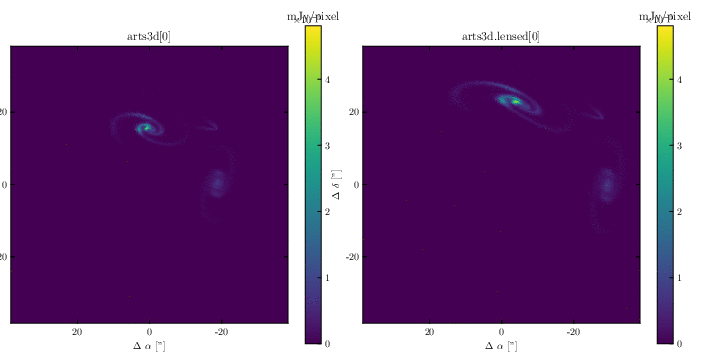

<Figure size 432x288 with 0 Axes>

In [83]:
nchan=header['NAXIS3']
stepchan= int(np.maximum(np.floor(int(nchan/20)),1))
vmax=np.nanmax(out)
vmin=np.nanmin(out)
fignames=[]
for ichan in range(0,nchan,stepchan):
    
    #clear_output(wait=True)
    figname='mockup_arts3d_lensed.chmap/ch{:03d}'.format(ichan)+'.pdf'
    images=[out[ichan,:,:],out_lensed[ichan,:,:]]
    titles=['arts3d['+'{}'.format(ichan)+']','arts3d.lensed['+'{}'.format(ichan)+']']
    im_grid(images*1000,header,offset=True,units=['mJy/pixel','mJy/pixel'],
            titles=titles,nxy=(2,1),figsize=(10,5),figname=figname,vmins=[vmin,vmin],vmaxs=[vmax,vmax]) ;
    fignames.append(figname) 

make_gif(fignames,'mockup_arts3d_lensed.chmap/chmap.gif')
show_gif('mockup_arts3d_lensed.chmap/chmap.gif')

## Lensing Model Tests

Here we perform some lensing-relaed code tests

### Compare Ray-tracing Precisions

**Used ISM3D Functions:**

* `im3d.arts.apmodel2d.eval_apmodel2d`
* `im3d.arts.lens.sie_rt`

In `im3d.arts.lens.sie_rt`, we have implemented two ray-tracing methods for a SIE potential:
* method='asb': from A. S. Bolton (NOAO): http://www.physics.utah.edu/~bolton/python_lens_demo/
* method='ls': from lenstronomy: https://github.com/sibirrer/lenstronomy

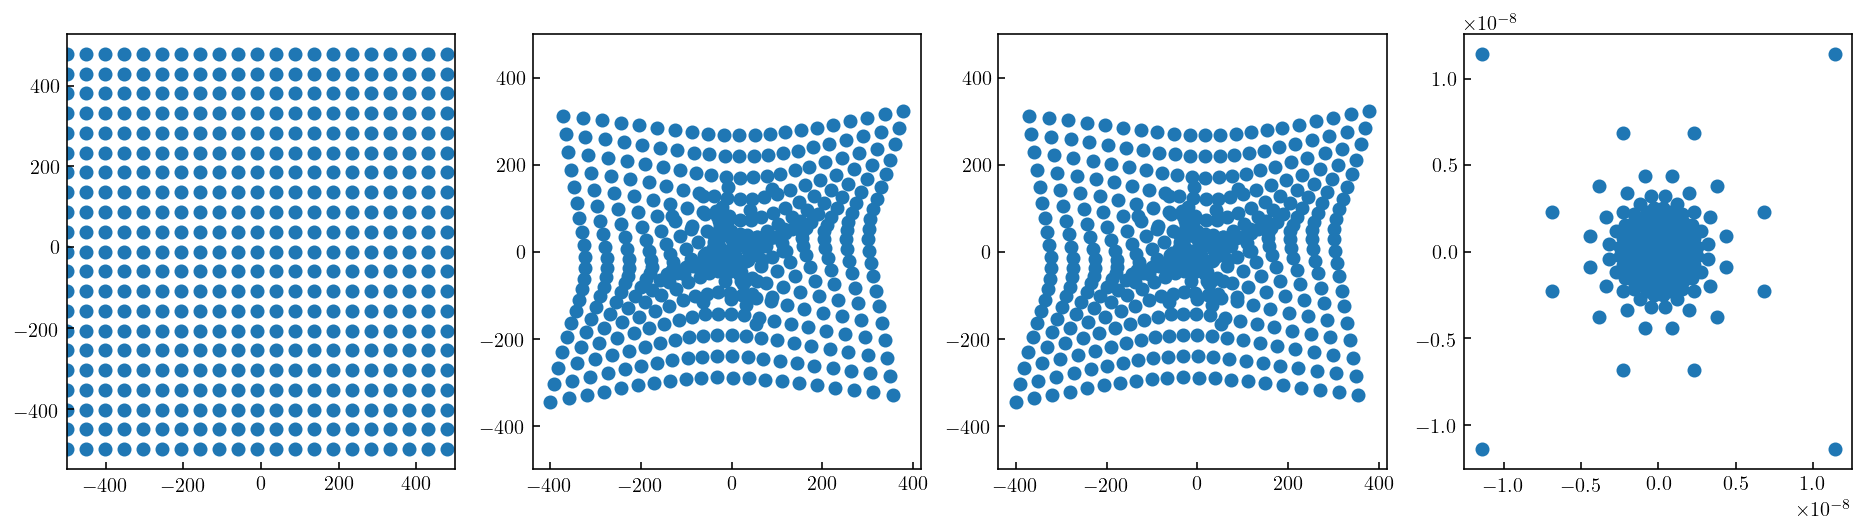

In [7]:
x=np.linspace(-500,500,512)
y=np.linspace(-500,500,512)
xx,yy=np.meshgrid(x,y)

#%lprun -f sie_rt 
x_ls,y_ls=sie_rt(xx,yy,theta_e=200,xc=0,yc=0,pa=20,q=0.5,method='ls')
x_asb,y_asb=sie_rt(xx,yy,theta_e=200,xc=0,yc=0,pa=20,q=0.5,method='asb')

figname='lens_apmodel2d_rt.pdf'
fig, axs = plt.subplots(1,4, figsize=(16,4))
axs=np.array(axs).reshape(-1)

axs[0].scatter(xx[::25,::25],yy[::25,::25])
axs[1].scatter(x_ls[::25,::25],y_ls[::25,::25])
axs[2].scatter(x_asb[::25,::25],y_asb[::25,::25])
axs[3].scatter(x_ls-x_asb,y_ls-y_asb)
axs[0].set_xlim(-500,500)
axs[1].set_ylim(-500,500)
axs[2].set_ylim(-500,500)

prepdir(figname)
fig.savefig(figname)

### Direct-Evaluate Method

**Used ISM3D Functions:**

* `im3d.arts.apmodel2d.eval_apmodel2d`
* `im3d.arts.lens.sie_rt`

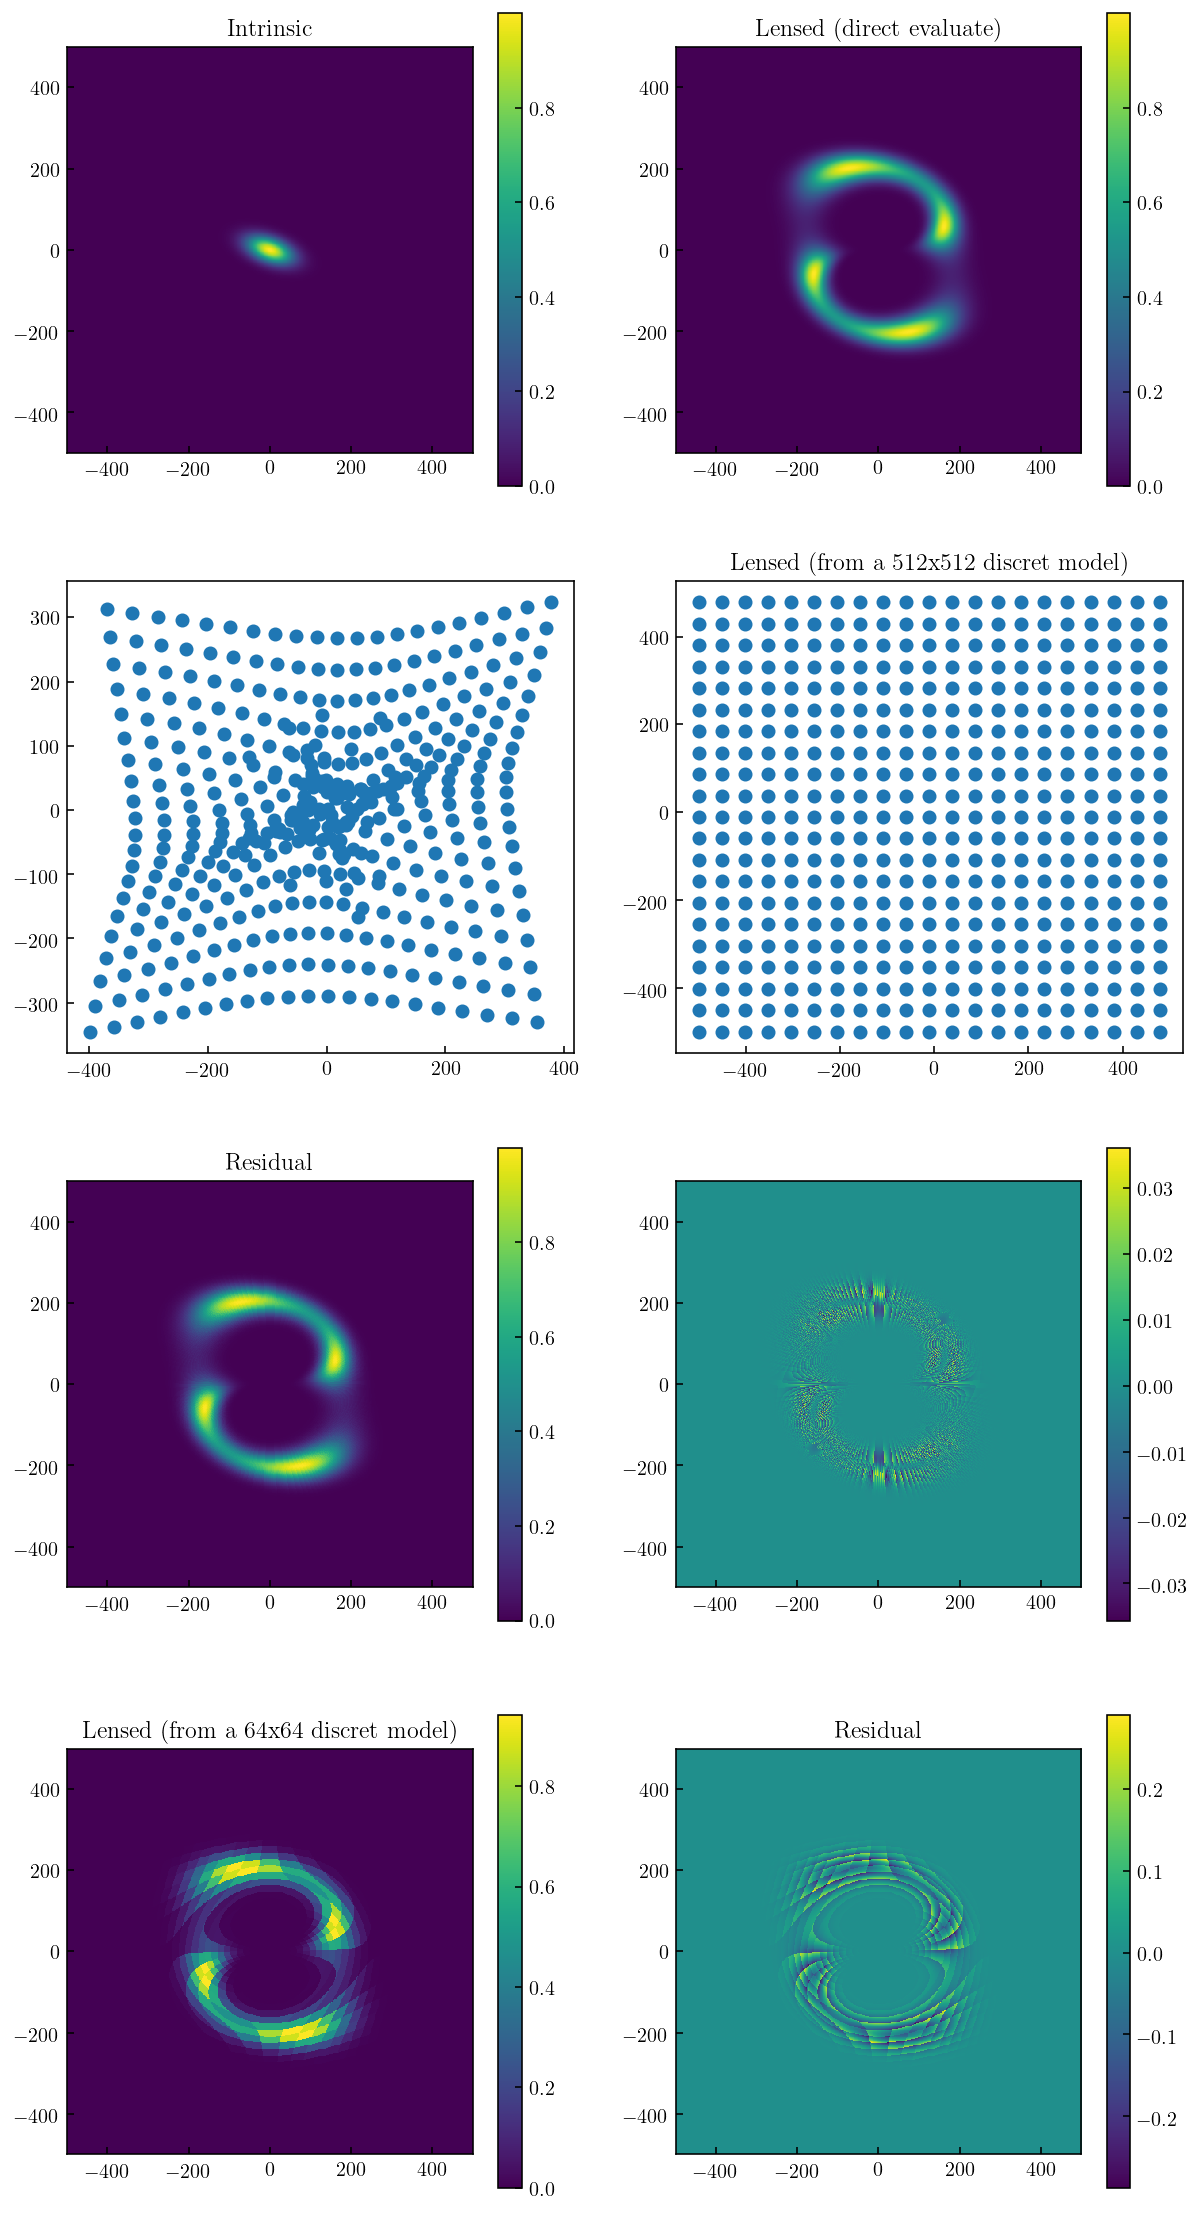

In [12]:
inpfile='../../input/mockup_lens.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)
mod_dict['obj5']


# make source

x=np.linspace(-500,500,512)
y=np.linspace(-500,500,512)
xx,yy=np.meshgrid(x,y)
source=eval_apmodel2d(mod_dict['obj5'],xx,yy)

# make lensed souce

xs,ys=sie_rt(xx,yy,theta_e=200,xc=0,yc=0,pa=20,q=0.5,method='ls')
source_lensed=eval_apmodel2d(mod_dict['obj5'],xs,ys)

cell=abs(x[0]-x[1])
ix=(xs-(-500))/cell
iy=(ys-(-500))/cell
source_lensed_cc=source[np.round(iy).astype(np.int),np.round(ix).astype(np.int)]

x_ccc=np.linspace(-500,500,64)
y_ccc=np.linspace(-500,500,64)

xx_ccc,yy_ccc=np.meshgrid(x_ccc,y_ccc)
source_ccc=eval_apmodel2d(mod_dict['obj5'],xx_ccc,yy_ccc)

cell_ccc=abs(x_ccc[0]-x_ccc[1])
ix_ccc=(xs-(-500))/cell_ccc
iy_ccc=(ys-(-500))/cell_ccc
source_lensed_ccc=source_ccc[np.round(iy_ccc).astype(np.int),np.round(ix_ccc).astype(np.int)]

### PLOT

figname='lens_apmodel2d.pdf'
fig, axs = plt.subplots(4,2, figsize=(10,20))
axs=np.array(axs).reshape(-1)

im0=axs[0].imshow(source,extent=[-500,500,-500,500])
cb0=fig.colorbar(im0, ax=axs[0])
im1=axs[1].imshow(source_lensed,extent=[-500,500,-500,500])
cb1=fig.colorbar(im1, ax=axs[1])
axs[0].set_title('Intrinsic')
axs[1].set_title('Lensed (direct evaluate)')

# plot source/lense plane sub-sampling points

axs[2].scatter(xs[::25,::25],ys[::25,::25])
axs[3].scatter(xx[::25,::25],yy[::25,::25])

# use a fine-sampling image

im4=axs[4].imshow(source_lensed_cc,extent=[-500,500,-500,500])
im5=axs[5].imshow(source_lensed_cc-source_lensed,extent=[-500,500,-500,500])
cb4=fig.colorbar(im4, ax=axs[4])
cb5=fig.colorbar(im5, ax=axs[5])
axs[3].set_title('Lensed (from a 512x512 discret model)')
axs[4].set_title('Residual')

# use a coarse-sampling image rather than analytical function

im6=axs[6].imshow(source_lensed_ccc,extent=[-500,500,-500,500])
im7=axs[7].imshow(source_lensed_ccc-source_lensed,extent=[-500,500,-500,500])
cb6=fig.colorbar(im6, ax=axs[6])
cb7=fig.colorbar(im7, ax=axs[7])
axs[6].set_title('Lensed (from a 64x64 discret model)')
axs[7].set_title('Residual')

prepdir(figname)
fig.savefig(figname)


### Sparse/Cloudlet Rendering Test1:

In this method, we create a regular 2D source image from a sparse-cloudlet source model and used ray-tracing from the image to source plane to create a sky image. This is a fast procedure although one should consider sufficnet oversampling to maintain precision requirements.

**Used ISM3D Functions:**

* `im3d.arts.sparse.clouds_from_disk3d`
* `im3d.arts.sparse.clouds_discretize_2d`
* `im3d.arts.lens.sie_rt`

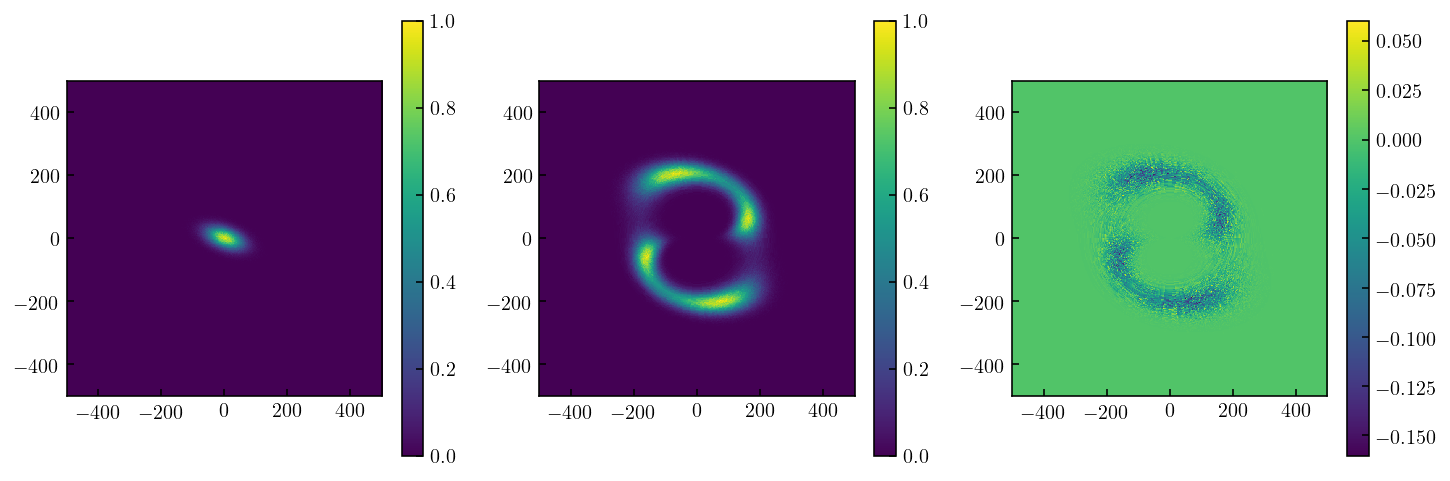

In [34]:
inpfile='../../input/mockup_lens.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)

clouds_from_disk3d(mod_dict['contdisk3'],nc=10**6,nv=20,seeds=[None]*4)
clouds_loc=mod_dict['contdisk3']['clouds_loc']
#sbProf=('sersic2d',0.1,1)
#clouds_loc,cloudmeta=clouds_morph(sbProf,seeds=[None,None,None],size=10**6)

im=clouds_discretize_2d(clouds_loc,range=[[-500,+500],[-500,+500]],bins=(512,512))
im/=np.max(im)

x=np.linspace(-500,500,513)
y=np.linspace(-500,500,513)
x=(x[:-1]+x[1:])/2
y=(y[:-1]+y[1:])/2
xx,yy=np.meshgrid(x,y)
xs,ys=sie_rt(xx,yy,theta_e=200,xc=0,yc=0,pa=20,q=0.5,method='ls')

cell=abs(x[0]-x[1])
ix=(xs-(-500))/(1000/512)
iy=(ys-(-500))/(1000/512)
im_lensed=im[np.round(iy-0.5).astype(np.int),np.round(ix-0.5).astype(np.int)]

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs=np.array(axs).reshape(-1)
am0=axs[0].imshow(im,extent=[-500,500,-500,500])
cb0=fig.colorbar(am0, ax=axs[0])


#axs[0].set_xlim(-400,400)
#axs[0].set_ylim(-400,400)
am1=axs[1].imshow(im_lensed,extent=[-500,500,-500,500])
cb1=fig.colorbar(am1, ax=axs[1])


source_lensed=eval_apmodel2d(mod_dict['obj5'],xs,ys)
am2=axs[2].imshow(im_lensed-source_lensed,extent=[-500,500,-500,500])
cb2=fig.colorbar(am2, ax=axs[2])


### Sparse/Cloudlet Rendering Test2:

In this method, we create a image-domain triangular mesh (one square pixel splitted into two traingles) and map the mesh from the image to source plane. The ray-tracing mapping can:

* idenity the image-plane location(s) of each point source model
* magnification factor in terms of flux contribution (with SB preserved, the source-to-image traignular size ratio provides the magniftication factor)
into can the magnification factor and 

This is a slow procedure and only created for testing purposes.

**Used ISM3D Functions:**

* `im3d.arts.sparse.clouds_from_disk3d`
* `im3d.arts.sparse.clouds_discretize_2d`
* `im3d.arts.lens.sie_rt`
* `im3d.arts.maths.geometry.points_in_triangle`

In [ ]:
inpfile='../../input/mockup_lens.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)

clouds_from_disk3d(mod_dict['contdisk3'],nc=10**6,nv=20,seeds=[None]*4)
clouds_loc=mod_dict['contdisk3']['clouds_loc']
#sbProf=('sersic2d',0.1,1)
#clouds_loc,cloudmeta=clouds_morph(sbProf,seeds=[None,None,None],size=10**6)

im=clouds_discretize_2d(clouds_loc,range=[[-500,+500],[-500,+500]],bins=(512,512))

xp=clouds_loc.x.value
yp=clouds_loc.y.value
points = np.vstack((xp,yp)).T 

sx=np.linspace(-500,500,128)
sy=np.linspace(-500,500,128)
xx,yy=np.meshgrid(sx,sy)
xs,ys=sie_rt(xx,yy,theta_e=200,xc=0,yc=0,pa=20,q=0.5,method='ls')

cc=xx*0
def ray_tracing(xs,ys):
    cc=xs*0.0
    nxy=xs.shape
    for i in range(nxy[0]-1):
        for j in range(nxy[1]-1):
            cc1,ss1=points_in_triangle(xs[i,j],ys[i,j],xs[i+1,j],ys[i+1,j],xs[i+1,j+1],ys[i+1,j+1],
                xp,yp,count=True)
            cc2,ss2=Ppoints_in_triangle(xs[i,j],ys[i,j],xs[i+1,j+1],ys[i+1,j+1],xs[i,j+1],ys[i,j+1],
                xp,yp,count=True)            
            cc[i,j]=float(cc1)/ss1+float(cc2)/ss2
    return cc

%lprun -f PointInsideTriangle_method2  cc=ray_tracing(xs,ys)

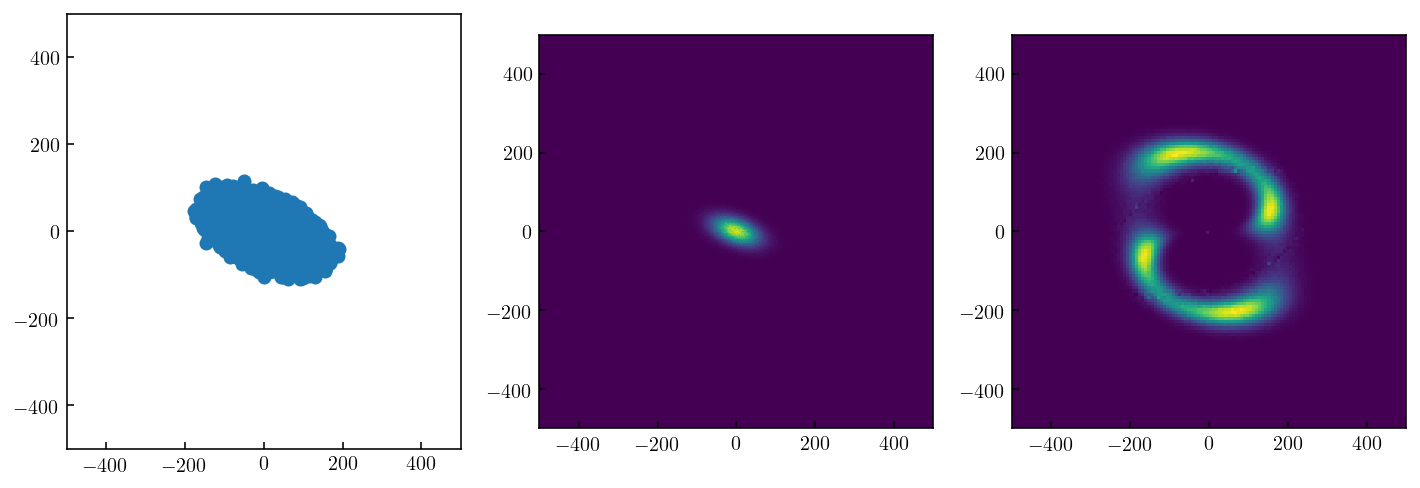

In [37]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs=np.array(axs).reshape(-1)
axs[0].scatter(clouds_loc.x,clouds_loc.y)
axs[0].set_xlim(-500,500)
axs[0].set_ylim(-500,500)
axs[1].imshow(im,extent=[-500,500,-500,500])
axs[2].imshow(cc,extent=[-500,500,-500,500])

### Sparse/Cloudlet Rendering Test3:

In this method, we use `lenstronomy.LensModel.Solver.lens_equation_solver` to locate image location(s) of point source model. This is not an effient way to build sky image from a sparse model, shown here for testing purposes.

In [52]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model import LensModel

theta_e=1;xc=0;yc=0;pa=0;q=1.0

e1=(1-q)/(1+q)*np.cos(2*pa/180*np.pi)
e2=(1-q)/(1+q)*np.sin(2*pa/180*np.pi)
        
lensModel = LensModel(lens_model_list=['SIE'])
kwargs_lens = [{'theta_E': theta_e, 'e1': e1, 'e2': e2, 
                'center_x': xc, 'center_y': yc}] 
        
lensEquationSolver = LensEquationSolver(lensModel=lensModel)
%time \
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, \
                                                             sourcePos_x=0.02, \
                                                             sourcePos_y=0.01)
print(x_img,y_img)

CPU times: user 90.5 ms, sys: 6.27 ms, total: 96.8 ms
Wall time: 93 ms
[0.91442714] [0.45721371]
